In [6]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict

### Globals

In [7]:
OUTPUT_PATH = 'outputs/'
FEATURES_PATH = 'features/'
ALGORITHMS = ['dp1', 'dp2', 'greedy', 'bf', 'bnb', 'cplex']
LEVELS = [1,2,3,4,5,6]
LEVELS_SIZE = [19198 ,9983, 6664, 4994, 3999, 3333]
FEATURES = ['num_elem',
            'cap',
            'cap_mean_w',
            'cap_median_w', 
            'cap_desv_w', 
            'mean_w_mean_v',
            'median_w_median_v', 
            'desv_w_desv_v',
            'max_w_min_w',
            'max_v_min_v',
            'mean_w',
            'median_w', 
            'desv_w', 
            'min_w', 
            'max_w', 
            'mean_v', 
            'median_v', 
            'desv_v', 
            'min_v', 
            'max_v',
            'p_coef' 
           ]

### Helpers

In [8]:
def get_features(lvl, id_):
    return np.array(open(FEATURES_PATH +str(lvl)+'/'+ str(id_),'r').read().split(), dtype=float)

def get_best(lvl, id_, t):
    best_fo = 0
    best_alg = 0
    best_time = 1000000
    for alg in ALGORITHMS:
        if lvl not in list(alg_data[alg].keys()): continue
        for res in alg_data[alg][lvl][id_]:
            if res[1] < t and res[0] >= best_fo:
                if res[1] < best_time:
                    best_alg = ALGORITHMS.index(alg)+1
                    best_time = res[1]
    return best_alg

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(7), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    plt.xticks(np.arange(7), ('NO', *ALGORITHMS))
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

### Reading outputs

In [9]:
output_files = os.listdir(OUTPUT_PATH)
alg_data = defaultdict(list)

print("Faltan los siguientes resultados:")
for alg in ALGORITHMS:
    alg_data[alg] = defaultdict(list)
    for lvl in LEVELS:
        filename = alg + "_" + str(lvl)
        if filename not in output_files: # En caso de que todavía no hayan resultados
            print(alg, lvl)
            continue
        alg_data[alg][lvl] = defaultdict(list)
        file = open(OUTPUT_PATH+filename,'r')
        for row in file:
            id_, fo, time = row.split()
            alg_data[alg][lvl][int(id_)].append([(float)(fo), (float)(time)])

Faltan los siguientes resultados:
dp1 6
dp2 3
dp2 4
dp2 5
dp2 6
greedy 5
greedy 6
cplex 6


In [10]:
train_data = []
train_label = []

count = 0

for lvl in LEVELS:
    print("level "+str(lvl)+"...")
    for id_ in range(LEVELS_SIZE[lvl-1]):
        fts = get_features(lvl, id_)
        for t in np.linspace(0.01,6,300):
            train_data.append([*fts, t+1])
            train_label.append(get_best(lvl, id_, t))
        count += 1

level 1...
level 2...
level 3...
level 4...
level 5...
level 6...


In [60]:
# comparing al ojo
lvl_ = 1
id_ = 100
for alg in ALGORITHMS:
    print(alg, alg_data[alg][lvl_][id_])
    
print('BEST: ',ALGORITHMS[get_best(lvl_,id_,1)-1])

dp1 [[753.0, 4e-05]]
dp2 [[753.0, 0.000521]]
greedy [[753.0, 4.8e-05]]
bf [[-1.0, -1.0]]
bnb [[753.0, 0.00126]]
cplex [[3426.0, 0.01586], [753.0, 0.016543]]
BEST:  dp1


In [91]:
data = pd.DataFrame(data=train_data, columns=[*FEATURES, 't'])

## NN

In [33]:
# TensorFlow and tf.keras# Tensor 
import tensorflow as tf
#from tensorflow import keras
#from keras.layers import Dropout, Dense
from keras import Sequential
from keras.models import Model   
from keras.layers import *
# Helper libraries
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

### Train and Test set

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.3, random_state=42)

### Saving

In [15]:
with open('X_train.csv', 'w') as FOUT:
    np.savetxt(FOUT, X_train)
with open('X_test.csv', 'w') as FOUT:
    np.savetxt(FOUT, X_test)
with open('y_train.csv', 'w') as FOUT:
    np.savetxt(FOUT, y_train)
with open('y_test.csv', 'w') as FOUT:
    np.savetxt(FOUT, y_test)

### Loading

In [ ]:
y_train = np.loadtxt('y_train.csv', dtype=float)

In [ ]:
X_train = np.loadtxt('X_train.csv', dtype=float)

### Model

In [16]:
model = Sequential([
    Dense(128, input_shape = (22,), activation=tf.nn.relu),
    Dropout(0.5),
    Dense(64, activation=tf.nn.relu),
    Dropout(0.5), 
    Dense(64, activation=tf.nn.relu),
    Dropout(0.5), 
    Dense(7, activation=tf.nn.softmax)
])

In [17]:
model.compile(optimizer=tf.train.AdamOptimizer(with open('y_test.csv', 'w') as FOUT:
    np.savetxt(FOUT, y_test)), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
history = model.fit(np.array(X_train), np.array(y_train), epochs=6)

Epoch 1/6
10115910/10115910 [==============================] - 277s 27us/step - loss: 1.0995 - acc: 0.6367
Epoch 2/6
10115910/10115910 [==============================] - 273s 27us/step - loss: 0.9625 - acc: 0.7345
Epoch 3/6
10115910/10115910 [==============================] - 272s 27us/step - loss: 0.7749 - acc: 0.7500
Epoch 4/6
10115910/10115910 [==============================] - 279s 28us/step - loss: 0.7798 - acc: 0.7556
Epoch 5/6
10115910/10115910 [==============================] - 270s 27us/step - loss: 0.7647 - acc: 0.7515
Epoch 6/6
10115910/10115910 [==============================] - 272s 27us/step - loss: 0.8540 - acc: 0.7471


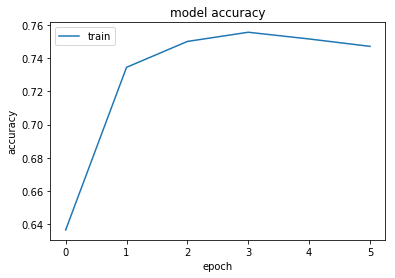

In [20]:
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

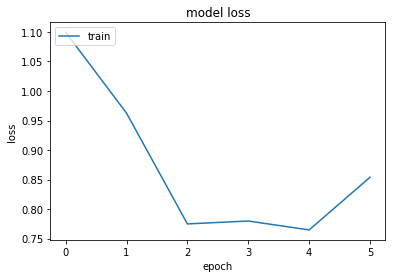

In [21]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train, verbose=1)

### Evaluate Accuracy (test set)

In [24]:
X_test = np.loadtxt('X_test.csv', dtype=float)
y_test = np.loadtxt('y_test.csv', dtype=float)

In [25]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

4335390/4335390 [==============================] - 48s 11us/step
Test accuracy: 0.7783408182425288


### Individual Predictions

In [26]:
predictions = model.predict(X_test)

In [27]:
with open('preditions.csv', 'w') as FOUT:
    np.savetxt(FOUT, predictions)

In [30]:
predictions = np.loadtxt('preditions.csv')

[ 3.10000000e+01  6.60000000e+01  2.24588364e+00  2.44444444e+00
  3.80206772e+00  6.15540541e-01  5.74468085e-01  6.67653928e-01
  6.00000000e+01  8.50000000e+01  2.93870968e+01  2.70000000e+01
  1.73589754e+01  5.00000000e+00  6.50000000e+01  4.77419355e+01
  4.70000000e+01  2.59999600e+01  6.00000000e+00  9.10000000e+01
 -5.06673851e-02  5.63772575e+00]


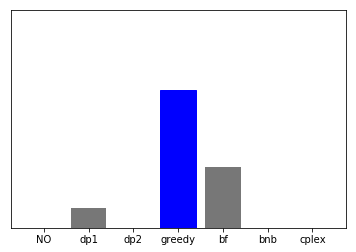

In [31]:
# rojo predicho
# azul verdadero
i = 4
print(X_test[i])
plt.figure()
plot_value_array(i, predictions,  np.array(y_test, dtype=int))

### Confusion matrix

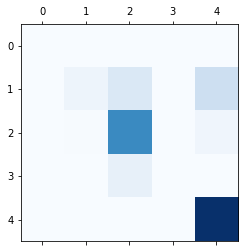

In [34]:
best_predictions = np.argmax(predictions,axis=1)

cm = sklearn.metrics.confusion_matrix(np.array(y_test, dtype=int), best_predictions)

fig, ax = plt.subplots()

ax.matshow(cm, cmap=plt.cm.Blues)

In [37]:
set(y_test)

{0.0, 1.0, 3.0, 4.0, 5.0}

In [35]:
cm

array([[      0,       0,       0,       0,    5638],
       [      0,   97312,  278940,       0,  420019],
       [      0,   11453, 1294524,       0,   81379],
       [      0,       0,  157657,       0,       0],
       [      0,       0,    5893,       0, 1982575]])

In [24]:
sample = np.array(X_test[0])
sample = (np.expand_dims(sample,0))
predictions_single = model.predict(sample)

print(predictions_single)

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [30]:
y_test[0]

6.0